# Quick start

Let's set up a simple emulator for scattering of 14.1 MeV protons on $^{27}$Al, using the [Koning-Delaroche](https://www.sciencedirect.com/science/article/pii/S0375947402013210?casa_token=qS1v6U4xDQEAAAAA:NIi9D5LpP3f05AMwRnvbQ6or8hSvXoEIgKBV56KA4l9aObCOVDAndmuCeIH77iuzoXMOOlAMyw) optical potential for the proton-nucleus interaction.

In [1]:
import rose
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
# useful constants
AMU = 931.494102  # MeV/c^2, Particle Data Group
MASS_N = 1.008665 * AMU  # MeV/c^2 PDG
MASS_P = 1.007276 * AMU  # MeV/c^2 PDG
MASS_CHARGED_PION = 139.57039  # MeV/c^2

In [3]:
# set up kinematics

# for 27-Al
A = 27  
Z = 13

Ebinding = 283.88  # MeV, for 27-Al (from BMEX.dev)

# target mass
mt = Z * MASS_P + (A-Z) * MASS_N - Ebinding

# reduced mass
mu = mt * MASS_N / (mt + MASS_N)

# energetics and wavenumber
Elab = 14.1 # MeV
Ecom = Elab * mt / (MASS_N + mt)
k = np.sqrt(2 * mu * Ecom) / rose.constants.HBARC

# up to how many partial waves should we calculate?
l_max = 20

Let's set up our optical potential using parameter values from tables 8 and 9 in the [Koning-Delaroche paper](https://www.sciencedirect.com/science/article/pii/S0375947402013210?casa_token=qS1v6U4xDQEAAAAA:NIi9D5LpP3f05AMwRnvbQ6or8hSvXoEIgKBV56KA4l9aObCOVDAndmuCeIH77iuzoXMOOlAMyw).

In [4]:
# default KD parameters for 14.1 MeV protons
vv = rose.koning_delaroche.Vv(Ecom, 62.4, 0.0070, 0.000017, 7.0e-9, -9.93)
rv = 1.162
av = 0.665

wv = rose.koning_delaroche.Wv(Ecom, 15.2, 75, -9.93)
rwv = rv
awv = av

wd = rose.koning_delaroche.Wd(Ecom, 14.6, 0.0224, 11.5, -9.93)
rd = 1.290
ad = 0.510

vso = rose.koning_delaroche.Vso(Ecom, 6.0, 0.0035, -9.93)
wso = rose.koning_delaroche.Wso(Ecom, -3.1, 160, -9.93)
rso = 1.0
aso = 0.58
rwso = rso
awso = aso

R_C = 1.329

# 15 params total
parameters = np.array(
    [vv, rv, av, wv, rwv, awv, wd, rd, ad, vso, rso, aso, wso, rwso, awso]
)

# create a 15D box in parameter space bounded by the default KD param values +/- 50%
bounds = np.array(
    [
        parameters - np.fabs(parameters * 0.5),
        parameters + np.fabs(parameters * 0.5),
    ]
).T

In [32]:
# instantiate the interaction
interactions = rose.InteractionEIMSpace(
    rose.koning_delaroche.KD_simple,
    len(parameters),
    mu,
    Ecom,
    l_max,
    is_complex=True,
    spin_orbit_potential=rose.koning_delaroche.KD_simple_so,
    training_info=bounds,
    Z_1=1,
    Z_2=13,
    R_C=R_C,
)

In [33]:
from scipy.stats import qmc

# sample training and test points from within bounds
# 80/20% train/test division
test = qmc.scale(
    qmc.LatinHypercube(d=parameters.size).random(20), bounds[:, 0], bounds[:, 1]
)
train = qmc.scale(
    qmc.LatinHypercube(d=parameters.size).random(80), bounds[:, 0], bounds[:, 1]
)

In [34]:
# set up and train emulator using sensible defaults
emulator = rose.ScatteringAmplitudeEmulator.from_train(
    interactions,
    train,
    l_max,
    n_basis=20,
    angles=np.linspace(np.pi/181, np.pi, 180),
)

100%|███████████████████████████████████████████| 21/21 [01:55<00:00,  5.51s/it]


Now we have a trained emulator! Let's compare observables between the emulator and the high-fidelity solver using our test set of sampled parameters.

In [35]:
%%time

# run high-fidelity solver
HIFI_xs = []
for sample in tqdm(test):
    HIFI_xs.append( emulator.exact_xs(sample))

100%|███████████████████████████████████████████| 20/20 [05:46<00:00, 17.32s/it]

CPU times: user 5min 46s, sys: 1.27 s, total: 5min 47s
Wall time: 5min 46s


In [36]:
%%time

# run emulator
emu_xs = []
for sample in tqdm(test):
    emu_xs.append( emulator.emulate_xs(sample))

100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 47.91it/s]

CPU times: user 913 ms, sys: 2.27 s, total: 3.18 s
Wall time: 420 ms


Now let's plot the results!

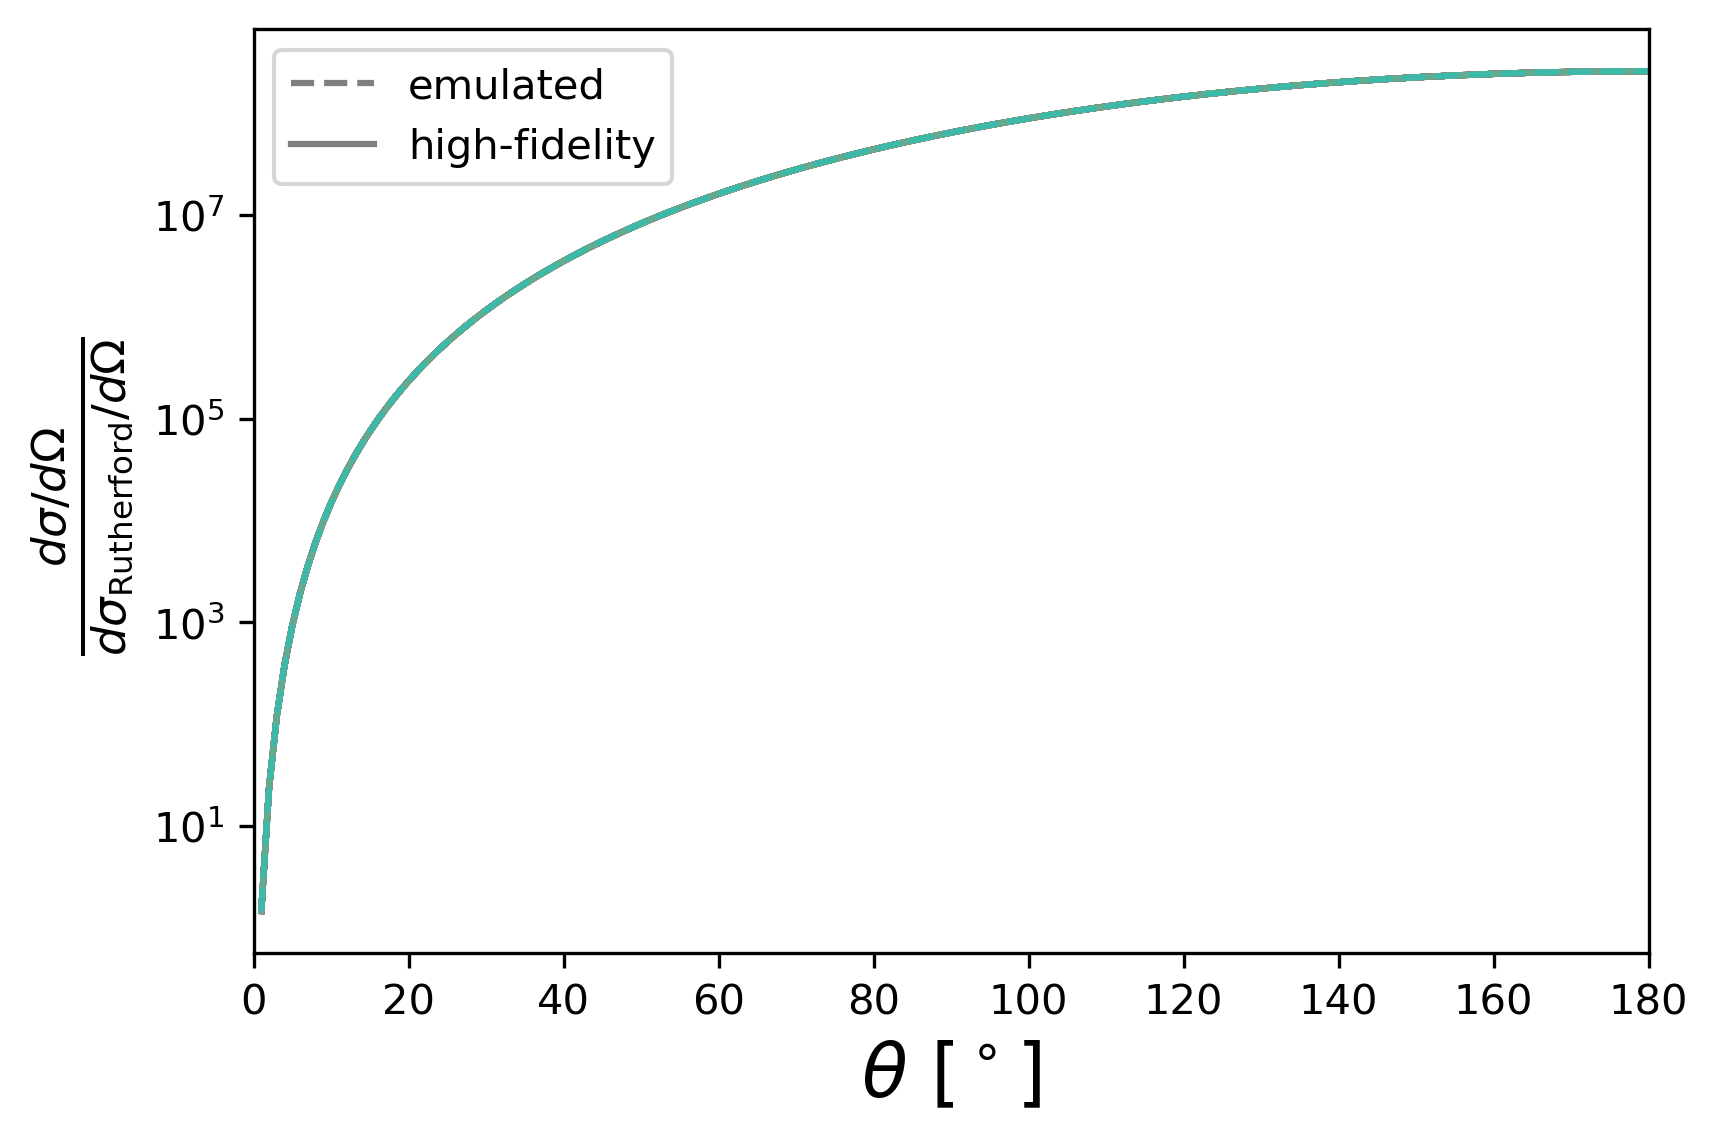

In [37]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(6, 4), dpi=300)
fig.patch.set_facecolor("white")

for i, sample in enumerate(test):
    x = emulator.angles * 180/(np.pi)
    
    # HIFI
    y_exact = HIFI_xs[i].dsdo 
    
    # emulated
    y_emu = emu_xs[i].dsdo 

    p = ax.plot(x, y_emu, "--", alpha=0.5)
    ax.plot(x, y_exact, color=p[0].get_color(), alpha=0.5)

legend_styles = [
    Line2D([0], [0], color="k", linestyle="--", alpha=0.5),
    Line2D([0], [0], color="k", alpha=0.5),
]
ax.legend(legend_styles, ["emulated", "high-fidelity"])
ax.set_yscale("log")
plt.xlim([0, 180])
plt.xlabel(r"$\theta$ [$^\circ$]", fontsize=18)
plt.ylabel(r"$\frac{d \sigma / d\Omega}{d \sigma_{\rm{Rutherford}}/d\Omega}}$ ", fontsize=16)
plt.show()

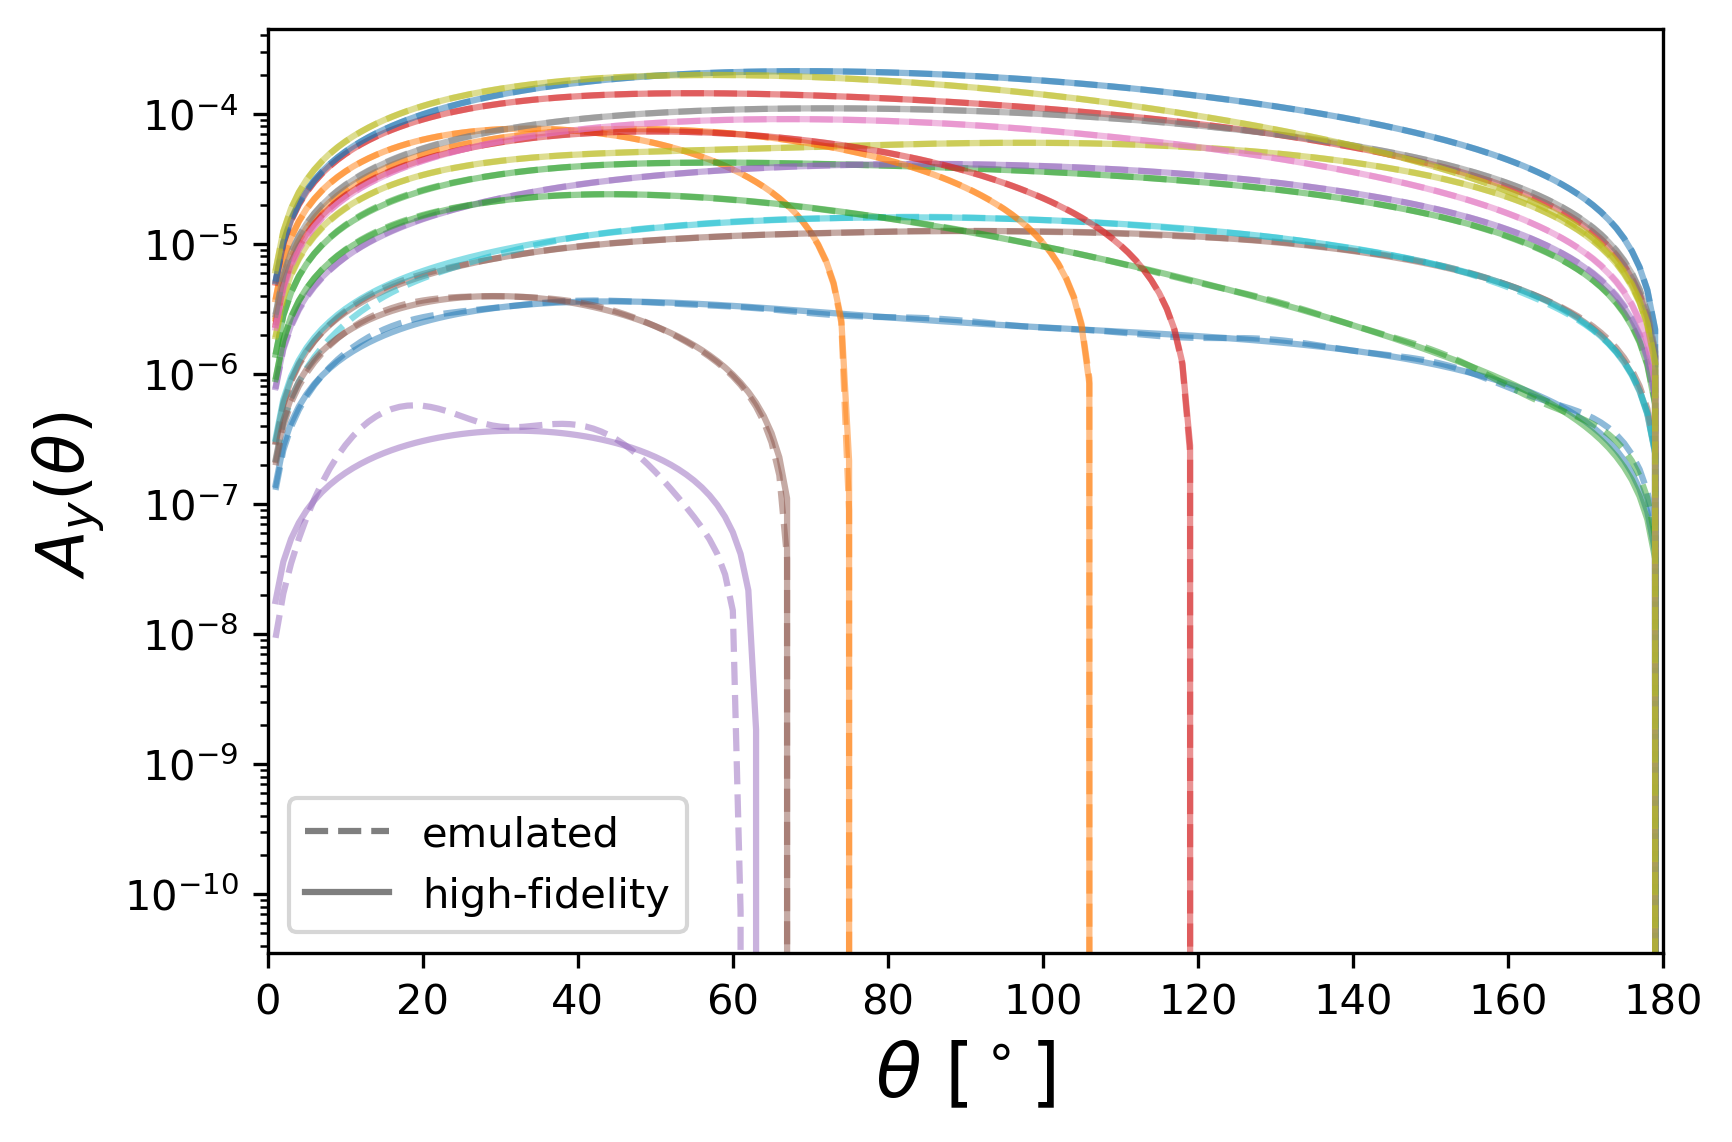

In [38]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)
fig.patch.set_facecolor("white")

for i, sample in enumerate(test):
    x = emulator.angles * 180/(np.pi)
    
    # HIFI
    y_exact = HIFI_xs[i].Ay 
    
    # emulated
    y_emu = emu_xs[i].Ay

    p = ax.plot(x, y_emu, "--", alpha=0.5)
    ax.plot(x, y_exact, color=p[0].get_color(), alpha=0.5)

legend_styles = [
    Line2D([0], [0], color="k", linestyle="--", alpha=0.5),
    Line2D([0], [0], color="k", alpha=0.5),
]
ax.legend(legend_styles, ["emulated", "high-fidelity"])
ax.set_yscale("log")
plt.xlim([0, 180])
plt.xlabel(r"$\theta$ [$^\circ$]", fontsize=18)
plt.ylabel(r"$A_y(\theta)$ ", fontsize=16)
plt.show()